#Классификация изображений


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange

warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##Обучаем сверточную сеть для задачи классификации изображений

In [3]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # средние и дисперсии по каналам
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=True,
    download=True,
    transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=16, 
    shuffle=True,
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    valset,
    batch_size=16, 
    shuffle=False,
    num_workers=1
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


In [4]:
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()

  if one_channel:
    plt.imshow(npimg, cmap='Greys')
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

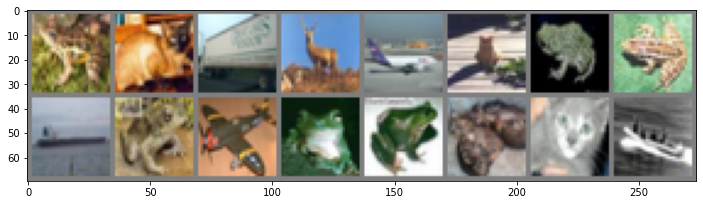

In [5]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [6]:
def plot_history(train_history, val_history, title='loss'):
  plt.figure()
  plt.title('{}'.format(title))
  plt.plot(train_history, label='train', zorder=1)

  points = np.array(val_history)
  steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

  plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
  plt.xlabel('train steps')

  plt.legend(loc='best')
  plt.grid()

  plt.show()

In [7]:
class ModelBaseline(nn.Module):
  def __init__(self):
    super(ModelBaseline, self).__init__()
    self.conv1   = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), 
                           padding=3//2)
    self.conv2   = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), 
                           padding=5//2)
    self.relu    = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # то же самое что и (2, 2)
    self.linear1 = nn.Linear(32 * 32 * 16 // 4, 128) # картинка 32 на 32 с 16 и maxpoling с шагом(stride) 2
    self.linear2 = nn.Linear(128, 10)
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    flattend = self.flatten(self.maxpool(x))
    x = self.relu(self.linear1(flattend))
    
    return self.linear2(x)

In [8]:
model_baseline = ModelBaseline()
model_baseline.to(device)

ModelBaseline(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [9]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs):
  train_loss_log = []
  train_acc_log = []
  val_loss_log = []
  val_acc_log = []

  for epoch in range(n_epochs):
    model.train() # переводим модель в режим обучения
    train_loss, train_size, train_acc = 0., 0, 0.

    for imgs, labels in tqdm(train_dataloader):
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad()
      y_pred = model(imgs)
      loss = criterion(y_pred, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_size += y_pred.size(0)
      train_loss_log.append(loss.data / y_pred.size(0))

      _, pred_classes = torch.max(y_pred, 1)
      train_acc += (pred_classes == labels).sum().item()
      train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))

    val_loss, val_size, val_acc = 0., 0, 0.
    model.eval() #переводим модель в валидационный режим
    with torch.no_grad():
      for imgs, labels in tqdm(val_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs)
        loss = criterion(pred, labels)
        val_loss += loss.item()
        val_size += pred.size(0)

        _, pred_classes = torch.max(pred, 1)
        val_acc += (pred_classes == labels).sum().item()
    val_loss_log.append(val_loss / val_size)
    val_acc_log.append(val_acc / val_size)

    #clear_output()
    #plot_history(train_loss_log, val_loss_log)
    #plot_history(train_acc_log, val_acc_log)

    print('Train loss: ', train_loss / train_size)
    print('Train accuracy: ', train_acc / train_size)
    print('Val loss: ', val_loss / val_size)
    print('Val accuracy: ', val_acc / val_size)

зафиксировать сид

In [10]:
def set_seed(seed):
  torch.backends.cudnn.deterministic = True
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  #random.seed(seed)
  #np.random.seed(seed)

set_seed(42)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_baseline.parameters(), lr=1e-03, momentum=0.9)

In [12]:
train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, 
      n_epochs=10)

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.10519380720138549
Train accuracy:  0.39594
Val loss:  0.08787343284487724
Val accuracy:  0.4929


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.08012232318520546
Train accuracy:  0.5428
Val loss:  0.07579161683321
Val accuracy:  0.5664


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.06887818930208683
Train accuracy:  0.60828
Val loss:  0.06736605934798717
Val accuracy:  0.6163


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.05973934381455183
Train accuracy:  0.66432
Val loss:  0.0627802505582571
Val accuracy:  0.6433


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.05256391913950443
Train accuracy:  0.70264
Val loss:  0.06265624097883701
Val accuracy:  0.646


  0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.046040571381747726
Train accuracy:  0.74052
Val loss:  0.06213037115633488
Val accuracy:  0.6592


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.03984663136571646
Train accuracy:  0.77742
Val loss:  0.06236219775378704
Val accuracy:  0.6641


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.0337031734200567
Train accuracy:  0.81228
Val loss:  0.06512660882472993
Val accuracy:  0.6679


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.028112812136635183
Train accuracy:  0.8424
Val loss:  0.06939359161108732
Val accuracy:  0.663


  0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss:  0.02262282690446824
Train accuracy:  0.8725
Val loss:  0.07910904107019305
Val accuracy:  0.6505


##Аугументация


In [13]:
import PIL

transform = transforms.Compose(
    [
     transforms.ColorJitter(hue=.05, saturation=.05),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, 
                                               shuffle=True, num_workers=1)
tesetset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                        download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, 
                                               shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


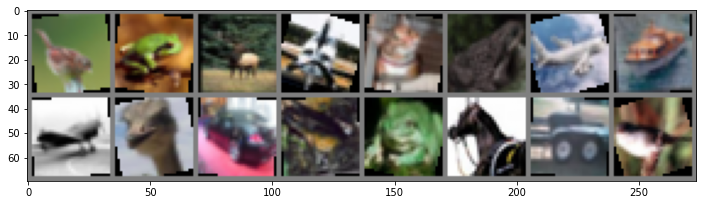

In [14]:
plt.figure(figsize=(12, 12))

images, labels = next(iter(train_dataloader))
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid)

In [15]:
model_base = ModelBaseline()
model_base.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_base.parameters(), lr=1e-03, momentum=0.95)

train(model_base, criterion, optimizer, train_dataloader, test_dataloader, 10)

Train loss:  0.055921019013673065
Train accuracy:  0.68396
Val loss:  0.054917835840582845
Val accuracy:  0.68738


  0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2147132cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/3125 [00:00<?, ?it/s]

Train loss:  0.05402639207154512
Train accuracy:  0.6949
Val loss:  0.0507051608812809
Val accuracy:  0.7149


##Как улучшить качество модели

Особенность VGG блока заключается в том, что повышение качество работы сети достигается увеличением числа последовательных блоков. При этом число фильтров в каждоми новаом блоке в два раза болше чем в предыдущем. 


###Dropout

Если сеть имеет сложную арихитектуру, то возможно переобучении - процесс в которм модель слишком сильно подстаариввается под тренироваочную выбооку и потом дает заниженно качестов на тестовой. Для борьбы с этим будем использовать dropout.

In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10),
    nn.Softmax()
)

In [17]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-03, momentum=0.9)

In [19]:
train(model, criterion, optimizer, train_dataloader, test_dataloader, 25)

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Train loss:  0.11950438157320023
Train accuracy:  0.55196
Val loss:  0.11632070486307144
Val accuracy:  0.60392
